# Creating Generative Art with Algorithms

This notebook attempts to introduce readers to popular open source software applications that use neural networks to generate images, text, and audio. We'll begin with an introduction to autoencoders, then proceed to examine a number of other neural network architectures, including Generative Adversarial Networks.

## Getting Started with Autoencoders

An autoencoder is a popular neural network structure that learns how to map input data to a lower dimensional space and vice-versa. In other words, an autoencoder provides us with two kinds of tools: one that maps from big data structures to compact data structures (the "encode" step), and one that maps from compact data structures back to big data structures (the "decode" step):

<img src='images/autoencoder.png'>

The first tool provided by the autoencoder is known as the "encoder". The encoder transforms a large data structure like an image (usually represented with thousands of images) into a compressed data structure (like a list of just two numbers).

The second tool provided by the autoencoder is known as the "decoder". The decoder transforms a compressed data structure (e.g. a list of just two numbers) into a large data structure (like an image).

Working together, the encoder and decoder give us resources we can use to generate new observations that look like our input data. By feeding an autoencoder images, for instance, we can generate new images. Let's see how this works below.

# Load Dependencies

The cell below loads all of the dependencies we will use in the code below.

In [1]:
# load special jupyter notebook helpers
%matplotlib inline

# import libraries we'll use below
import matplotlib.pyplot as plt
from scipy.misc import imread
from glob import glob
import numpy as np
import requests
import zipfile
import warnings
import os

warnings.filterwarnings('ignore')

# Prepare Training Data

In the code below, we'll download images from [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), a popular dataset for training machine learning models in computer vision. Then we'll plot a sample image from the dataset. Finally we'll combine all the downloaded images into a "multidimensional array" (a nested list) that we can use to train our model.

In [2]:
def download_celeb_a(outfile='celeba.zip'):
  if not os.path.exists(outfile): # download celeba data
    url = 'https://s3.amazonaws.com/lab-data-collections/celeba-sample.zip'
    open(outfile, 'wb').write(requests.get(url, allow_redirects=True).content)
  zipfile.ZipFile(outfile, 'r').extractall('.') # unzip the data
  
download_celeb_a()

In [3]:
# build a dataframe that contains the pixel values of each image
max_files = 20000
X = np.array([imread(i, mode='L') for i in glob('celeba-sample/*')[:max_files]]) / 255.0

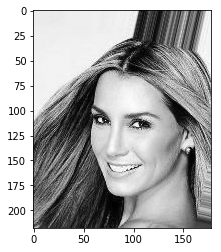

In [4]:
# X[0] is the first image in the collection - show that image
plt.imshow(X[0], cmap='gray')

# Build Autoencoder

Here's where the interesting work starts. We'll build the simplest autoencoder. This model will allow us to encode images into a 2-dimensional latent space, and then decode images from that latent space to the original image space.

In [5]:
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten, Dropout, LeakyReLU

class Autoencoder:
  def __init__(self, img_shape=(218, 178), latent_dim=2, n_layers=2, n_units=128, relu=False, dropout=False):
    if not img_shape: raise Exception('Please provide img_shape (height, width) in px')
    self.img_shape = img_shape # shape of all input images
    self.n_layers = n_layers # number of layers to include in the encoder and decoder
    self.n_units = n_units # number of units in each layer
    self.latent_dim = latent_dim # number of dimensions in innermost layer (a.k.a. latent space)
    self.relu = relu # whether to add relu layers in encoder/decoder
    self.dropout = dropout # whether to add dropout layers in encoder/decoder
    self.encoder = self.build_encoder()
    self.decoder = self.build_decoder()
    # attach the encoder and decoder
    i = Input(self.img_shape)
    z = self.encoder(i) # push observations into latent space
    o = self.decoder(z) # project from latent space to feature space
    self.model = Model(inputs=[i], outputs=[o])
    self.model.compile(loss='mse', optimizer='adam')
    
  def build_encoder(self):
    i = Input(self.img_shape)
    h = i
    h = Flatten()(h)
    for _ in range(self.n_layers):
      h = Dense(self.n_units)(h)
      if self.relu: h = LeakyReLU(alpha=0.2)(h)
      if self.dropout: h = Dropout(0.4)(h)
    o = Dense(self.latent_dim)(h)
    return Model(inputs=[i], outputs=[o])
  
  def build_decoder(self):
    i = Input((self.latent_dim,))
    h = i
    for _ in range(self.n_layers):
      h = Dense(self.n_units)(h)
      if self.relu: h = LeakyReLU(alpha=0.2)(h)
      if self.dropout: h = Dropout(0.4)(h)
    h = Dense(self.img_shape[0] * self.img_shape[1])(h)
    o = Reshape(self.img_shape)(h) # predict 1 frame
    return Model(inputs=[i], outputs=[o])
  
autoencoder = Autoencoder()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


# Train Autoencoder

Now lots show our autoencoder each of our input images to train. This process will allow the model to encode the images into a two-dimensional latent space (the innermost layer of the network), then decode that two-dimensional representation of the image into a full-blown image.

In [6]:
train = X[:10000]
test = X[-10000:]

autoencoder.model.fit(train, train, validation_data=(test, test), batch_size=64, epochs=8)

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 10000 samples
Epoch 1/8
10000/10000 [==============================] - 30s 3ms/step - loss: 0.1734 - val_loss: 0.0468
Epoch 2/8
10000/10000 [==============================] - 28s 3ms/step - loss: 0.0457 - val_loss: 0.0453
Epoch 3/8
10000/10000 [==============================] - 28s 3ms/step - loss: 0.0457 - val_loss: 0.0459
Epoch 4/8
10000/10000 [==============================] - 28s 3ms/step - loss: 0.0460 - val_loss: 0.0497
Epoch 5/8
10000/10000 [==============================] - 28s 3ms/step - loss: 0.0456 - val_loss: 0.0452
Epoch 6/8
10000/10000 [==============================] - 28s 3ms/step - loss: 0.0454 - val_loss: 0.0457
Epoch 7/8
10000/10000 [==============================] - 27s 3ms/step - loss: 0.0454 - val_loss: 0.0452
Epoch 8/8
10000/10000 [==============================] - 29s 3ms/step - loss: 0.0452 - val_loss: 0.0449


# Explore Autoencoder Latent Space

Now that the autoencoder is trained, let's project each image into the two-dimensional latent space and plot the positions of each image in that latent space.

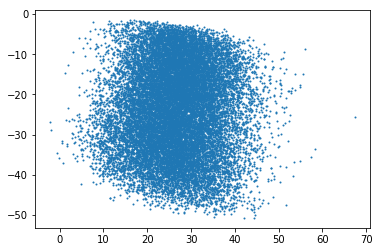

In [7]:
# transform each input image into the latent space
z = autoencoder.encoder.predict(X)

# plot the latent space
plt.scatter(z[:,0], z[:,1], marker='o', s=1)

# Sampling from the Latent Space

Now let's pick a random location in the two-dimensional latent space and ask the autoencoder to decode that two dimensional value into an image. This lets us generate fake images!

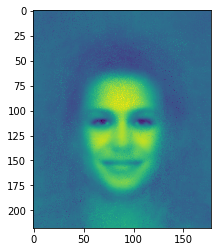

In [11]:
# sample from the region -50, -50
y = np.array([[30, -20]])
prediction = autoencoder.decoder.predict(y)
plt.imshow(prediction.squeeze())

# Interactive Latent Space Sampler

To explore the latent space more quickly, we can use the little widget below:

In [21]:
from IPython.display import IFrame

IFrame(src='https://s3.amazonaws.com/duhaime/blog/visualizations/celebsa-latent-space/index.html', width=700, height=400)

# Autoencoder Wrap-up

That's all it takes! In about thirty lines of code above, we built an autoencoder, trained that autoencoder on custom input data, then used our trained model to generate new, abstract faces. Pretty neat!

The autoencoder model we built above is of course rather simple. In the remainder of this workshop we'll experiment with more complicated neural network models to generate more interesting art. Let's dive in!